<a href="https://colab.research.google.com/github/kyledampier/GAITOR-DSI-ARIMA/blob/master/GAITOR_DSI_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://github.com/kyledampier/GAITOR-DSI-ARIMA/raw/master/data.zip
!unzip data.zip

In [582]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# remove warnings
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA', FutureWarning)

## Import Data

In [665]:
data_folder = os.path.join("data", "Finance")
time_series_dataset = "Implicit price index US1890  1974.csv" # non-stationary
# time_series_dataset = "AAPL_2006-01-01_to_2018-01-01.csv" # stationary 

data_path = os.path.join(data_folder, time_series_dataset)
data = pd.read_csv(data_path)

In [666]:
# Cleanup and Transform
data = data.drop("Unnamed: 0", axis=1)
data['log_x'] = list(map(math.log, data['x']))
data.head()

,x,log_x
0,24.858,3.213180
1,24.501,3.198714
2,23.675,3.164420
3,24.000,3.178054
4,22.540,3.115292


In [669]:
target_col = 'log_x'

# ARIMA from Scratch

## Auto-Regression

The RMSE is : 0.02893734719024808, Value of p: 5


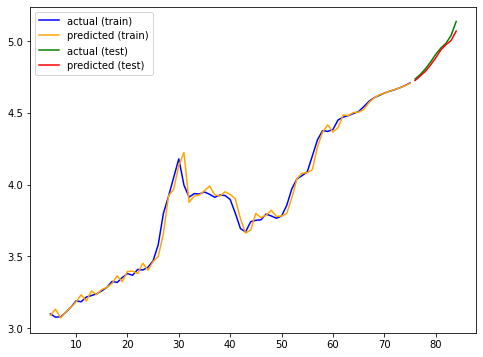

In [670]:
def AR(data, p, col=target_col, train_size=0.8, show_plot=False):
  '''
  Returns train (DataFrame), test (DataFrame), theta (float), intercept (float), error (float).
  Example usage:
    df_train, df_test, theta, intercept, rmse = AR(data, 10, col="Close", train_size=0.9, show_plot=True)
  '''
  temp = data
  train_cols = []

  # generate lagged data
  for i in range(1, p+1):
    temp[f'shifted_{i}'] = data[col].shift(i)
    train_cols.append(f'shifted_{i}')
  
  # seperate into train and test dataset
  train_size = int(train_size * temp.shape[0])
  train = pd.DataFrame(temp[0:train_size])
  test = pd.DataFrame(temp[train_size:])
  train = train.dropna()

  # run linear regression to generate the coefficents of lagged terms
  lr = LinearRegression()
  lr.fit(train[train_cols], train[col])

  # calculate predicted
  theta = lr.coef_.T
  intercept = lr.intercept_
  train['predicted'] = train[train_cols].dot(theta) + intercept
  test['predicted'] = test[train_cols].dot(theta) + intercept

  # compare actual vs. predicted
  error = np.sqrt(mean_squared_error(test[col], test['predicted']))
  print(f"The RMSE is : {error}, Value of p: {p}")

  if show_plot:
    fig = plt.figure(figsize=(8,6))
    plt.plot(train[col], color='blue', label="actual (train)")
    plt.plot(train['predicted'], color='orange', label="predicted (train)")
    plt.plot(test[col], color='green', label="actual (test)")
    plt.plot(test['predicted'], color='red', label="predicted (test)")
    plt.legend(loc="upper left")
  
  return train, test, theta, intercept, error

_ = AR(data, 5, train_size=0.9, show_plot=True)

In [671]:
best_RMSE = 100000000000
best_p = -1

for i in range(1,30):
  [df_train, df_test, theta, intercept, RMSE] = AR(data, i)
  if(RMSE < best_RMSE):
    best_RMSE = RMSE
    best_p = i
  
print(f"Best lag value (p): {best_p}")

The RMSE is : 0.023433719618527447, Value of p: 1
The RMSE is : 0.024464772903814026, Value of p: 2
The RMSE is : 0.022484665043753405, Value of p: 3
The RMSE is : 0.023651846388056483, Value of p: 4
The RMSE is : 0.021175896313559442, Value of p: 5
The RMSE is : 0.02408338533016103, Value of p: 6
The RMSE is : 0.02292437758734709, Value of p: 7
The RMSE is : 0.024191624973711166, Value of p: 8
The RMSE is : 0.023525104023946555, Value of p: 9
The RMSE is : 0.02521309513893295, Value of p: 10
The RMSE is : 0.026113185342984648, Value of p: 11
The RMSE is : 0.025824317405866513, Value of p: 12
The RMSE is : 0.02326999750771807, Value of p: 13
The RMSE is : 0.024357786150076423, Value of p: 14
The RMSE is : 0.023001301805089976, Value of p: 15
The RMSE is : 0.024907329902531174, Value of p: 16
The RMSE is : 0.0203235525603634, Value of p: 17
The RMSE is : 0.023559766227993013, Value of p: 18
The RMSE is : 0.026083753467267237, Value of p: 19
The RMSE is : 0.029391160569407902, Value of p

The RMSE is : 0.014094743691548624, Value of p: 17


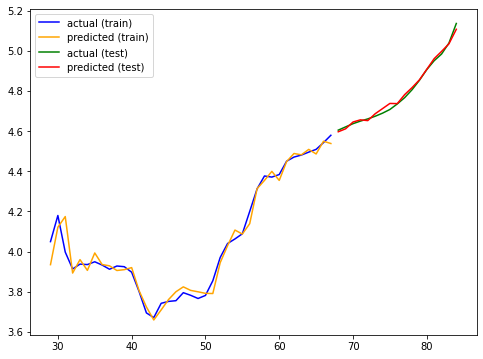

In [672]:
df_train, df_test, theta, intercept, rmse = AR(data, best_p, train_size=0.8, show_plot=True)

## ADF Check

In [675]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print("\t"+label+': '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

In [676]:
df_testing = pd.DataFrame(np.log(data[target_col]).diff().diff(10))
adf_check(df_testing[target_col].dropna())

Augmented Dickey-Fuller Test:
	ADF Test Statistic: -2.97462127494253
	p-value: 0.03733338956064504
	Number of Lags Used: 5
	Number of Observations Used: 68
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


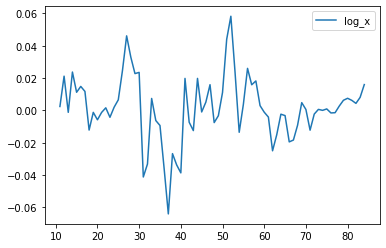

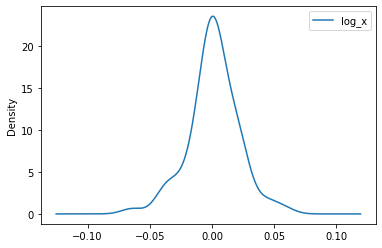

In [677]:
df_testing.plot()
df_testing.plot(kind='kde')

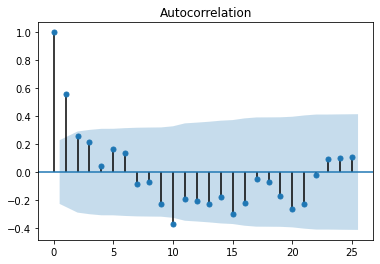

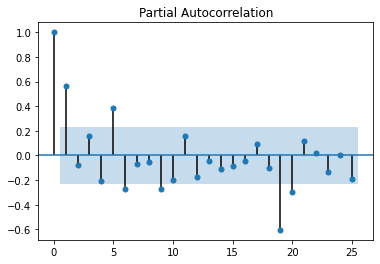

In [678]:
ACF = plot_acf(df_testing.dropna(),lags=25)
PACF = plot_pacf(df_testing.dropna(),lags=25)

## Moving Average

The RMSE is : 0.01746523432063657, Value of n: 3


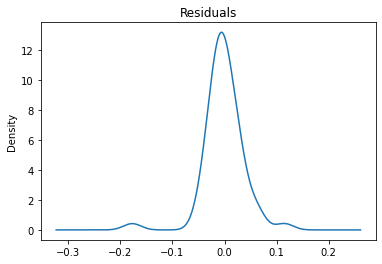

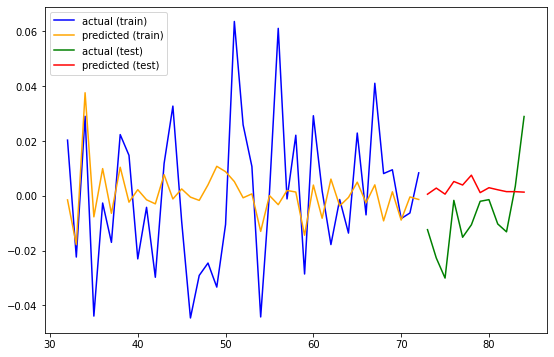

In [679]:
def get_residuals(train, test, actual=target_col, predicted='predicted', show_plot=False):
  df_c = pd.concat([train, test])
  df_c['residuals'] = df_c[actual] - df_c[predicted]

  if show_plot:
    df_c['residuals'].plot(kind='kde', title="Residuals")

  return df_c

def MA(res, q, col=target_col, train_size=0.8, show_plot=False):
  # create lagged dataset
  train_cols = []
  for i in range(1, q+1):
    res[f'shifted_res_{i}'] = res['residuals'].shift(i)
    train_cols.append(f'shifted_res_{i}')
  
  # split dataset into train and test
  train_size = (int)(0.8 * res.shape[0])
  train = pd.DataFrame(res[0:train_size])
  test = pd.DataFrame(res[train_size:res.shape[0]])

  train = train.dropna()
  X_train = train[train_cols].values.reshape(-1,q)
  y_train = train['residuals'].values.reshape(-1,1)

  # run linear regression on training dataset
  lr = LinearRegression()
  lr.fit(X_train, y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  train['predicted_res'] = X_train.dot(lr.coef_.T) + lr.intercept_

  X_test = test[train_cols].values.reshape(-1,q)
  test['predicted_res'] = X_test.dot(lr.coef_.T) + lr.intercept_

  RMSE = np.sqrt(mean_squared_error(test['residuals'], test['predicted_res']))
  print(f"The RMSE is : {RMSE}, Value of n: {q}")

  if show_plot:
    fig = plt.figure(figsize=(9,6))
    plt.plot(train['residuals'], color='blue', label="actual (train)")
    plt.plot(train['predicted_res'], color='orange', label="predicted (train)")
    plt.plot(test['residuals'], color='green', label="actual (test)")
    plt.plot(test['predicted_res'], color='red', label="predicted (test)")
    plt.legend(loc="upper left")
  
  return [train, test, theta, intercept, RMSE]

df_res = get_residuals(df_train, df_test, show_plot=True)
df2_train, df2_test, theta, intercept, rmse = MA(df_res, 3, show_plot=True)
df_all = pd.concat([df2_train, df2_test])

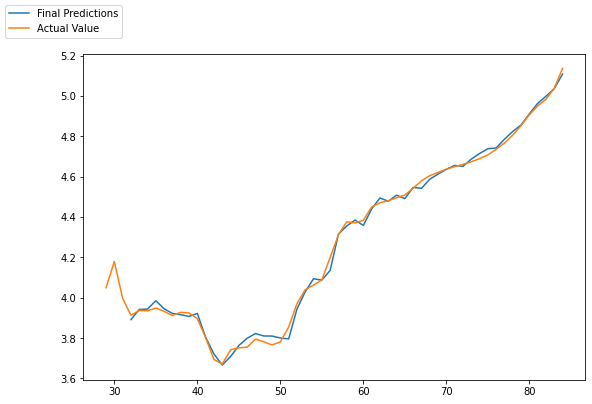

In [680]:
df_res['final_predicted_vals'] = df_res['predicted'] + df_all['predicted_res']
fig = plt.figure(figsize=(9,6))
df_res['final_predicted_vals'].plot(label="Final Predictions")
df_res[target_col].plot(label="Actual Value")
fig.legend(loc="upper left")

In [681]:
best_RMSE=100000000000
best_q = -1

for i in range(1,13):
  [res_train,res_test,theta,intercept,RMSE] = MA(pd.DataFrame(df_res['residuals']), i)
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_q = i
  
print(best_q)

The RMSE is : 0.015613731507464337, Value of n: 1
The RMSE is : 0.016641485620761967, Value of n: 2
The RMSE is : 0.01746523432063657, Value of n: 3
The RMSE is : 0.01553860642118128, Value of n: 4
The RMSE is : 0.015523083639980619, Value of n: 5
The RMSE is : 0.016179411700828792, Value of n: 6
The RMSE is : 0.017085715186830844, Value of n: 7
The RMSE is : 0.016093387617167967, Value of n: 8
The RMSE is : 0.01827022750441262, Value of n: 9
The RMSE is : 0.015663905522723506, Value of n: 10
The RMSE is : 0.015881931538698105, Value of n: 11
The RMSE is : 0.015459286366330035, Value of n: 12
12


The RMSE is : 0.015459286366330035, Value of n: 12


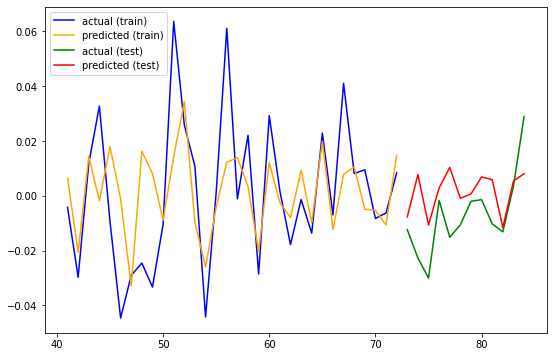

In [682]:
res_train, res_test, theta, intercept, rmse = MA(df_res, best_q, show_plot=True)

In [683]:
df_c = pd.concat([res_train, res_test])
df_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 41 to 84
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   x                     44 non-null     float64
 1   log_x                 44 non-null     float64
 2   shifted_1             44 non-null     float64
 3   shifted_2             44 non-null     float64
 4   shifted_3             44 non-null     float64
 5   shifted_4             44 non-null     float64
 6   shifted_5             44 non-null     float64
 7   shifted_6             44 non-null     float64
 8   shifted_7             44 non-null     float64
 9   shifted_8             44 non-null     float64
 10  shifted_9             44 non-null     float64
 11  shifted_10            44 non-null     float64
 12  shifted_11            44 non-null     float64
 13  shifted_12            44 non-null     float64
 14  shifted_13            44 non-null     float64
 15  shifted_14            44

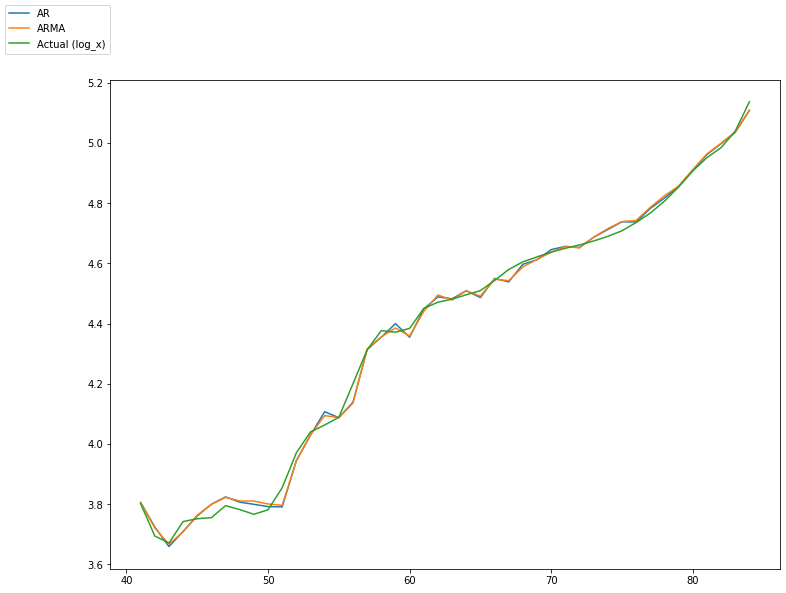

In [684]:
fig = plt.figure(figsize=(12,9))
df_c['predicted'].plot(label="AR")
df_c['final_predicted_vals'].plot(label="ARMA")
df_c[target_col].plot(label=f"Actual ({target_col})")
fig.legend(loc="upper left")

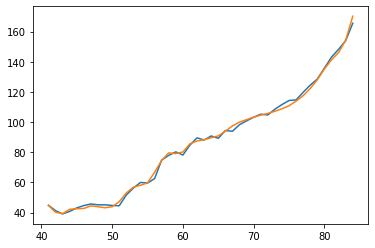

In [685]:
df_c['final_predicted_vals_transformed'] = list(map(math.exp, df_c['final_predicted_vals']))

df_c['final_predicted_vals_transformed'].plot()
df_c['x'].plot()

# Python Libraries

In [659]:
# best_order = (best_p, 1, best_q)
best_order = (5,1,2)

model = ARIMA(data[target_col], order=best_order)
model_fit = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [660]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.x   No. Observations:                   84
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -200.814
Method:                       css-mle   S.D. of innovations              2.623
Date:                Mon, 17 Oct 2022   AIC                            419.628
Time:                        17:14:42   BIC                            441.505
Sample:                             1   HQIC                           428.423
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2463      1.298      1.731      0.084      -0.298       4.790
ar.L1.D.x      0.2328      0.566      0.411      0.681      -0.877       1.343
ar.L2.D.x     -0.0280      0.241     -0.116      0.9

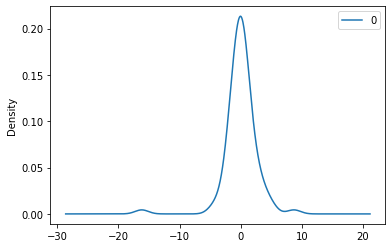

In [661]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=[99.2852653], expected=100.0
predicted=[101.44962461], expected=101.64
predicted=[102.82954199], expected=103.28
predicted=[104.66064351], expected=104.61
predicted=[105.67633388], expected=105.76
predicted=[106.94089656], expected=107.17
predicted=[108.42864724], expected=108.83
predicted=[110.1901718], expected=110.86
predicted=[112.38168753], expected=113.95
predicted=[116.01878822], expected=117.58
predicted=[119.63050754], expected=122.3
predicted=[125.09456066], expected=128.21
predicted=[131.33767503], expected=135.24
predicted=[139.04220479], expected=141.35
predicted=[144.26699521], expected=146.12
predicted=[148.84261935], expected=154.3
predicted=[159.66191008], expected=170.17
Test RMSE: 3.320


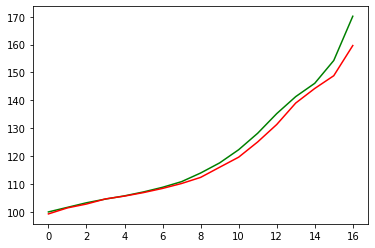

In [662]:
X = data['x']

train = size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

predictions = list()

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test.iloc[t]
	history.append(obs)
	print(f'predicted={yhat}, expected={obs}')

# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
plt.plot(test.reset_index(drop=True), color="green")
plt.plot(predictions, color='red')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


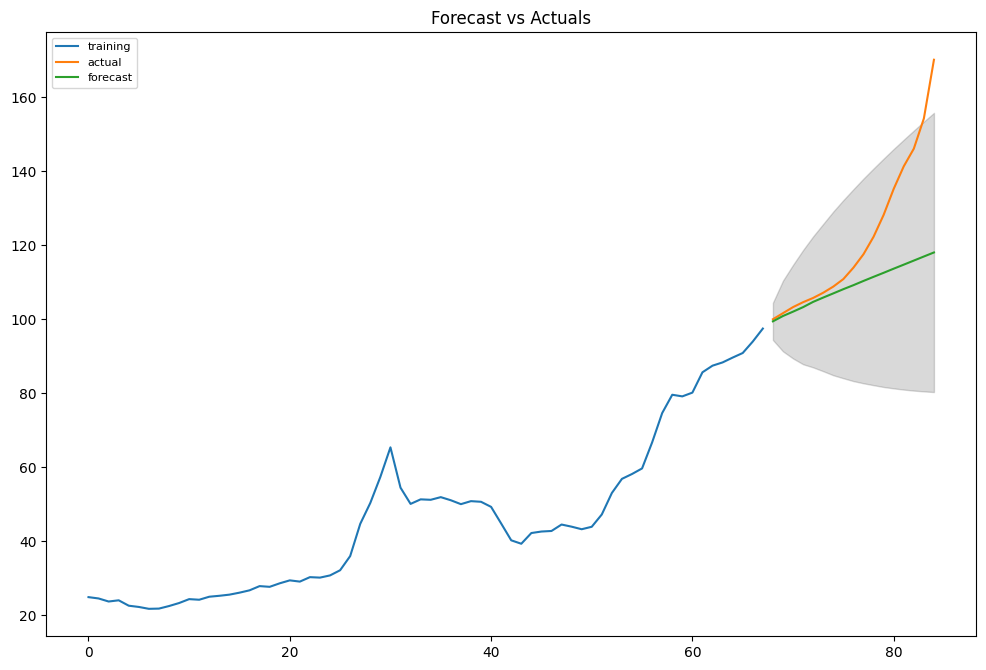

In [663]:
# Build Model
model = ARIMA(train, order=best_order)  
fitted = model.fit(disp=-1)

# Forecast
fc, _, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,8), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)